Early stopping is a technique used to prevent overfitting when training machine learning models, including XGBoost models. Overfitting occurs when a model is trained for too many iterations and starts to memorize the training data instead of learning to generalize from it. 

Early stopping works by monitoring the model’s performance on a validation dataset during training. If the performance on the validation dataset stops improving for a certain number of iterations, the training is stopped early and the best iteration is used as the final model.

In XGBoost, you can use early stopping by specifying a validation dataset and setting the early_stopping_rounds parameter when calling the fit method. For example, if you set early_stopping_rounds=10, training will stop if the performance on the validation dataset doesn’t improve for 10 consecutive rounds.

Early stopping can help you save time and computational resources by stopping the training process early if it’s not likely to result in further improvements. It can also help you avoid overfitting by preventing the model from being trained for too many iterations.

we can achieve early stopping in XGBoost models when we call the `.fit` method.

## 10.1 Early Stopping Rounds

Here are the results of XGBoost using out-of-the-box behavior. By default, the model will
create 100 trees. This model labels about 74% of the test examples correctly:

In [1]:
import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier
import urllib
import zipfile

from EffectiveXGBoost import *

In [2]:
path_url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
file_name = 'kaggle-survey-2018.zip'
dataset = 'multipleChoiceResponses.csv'

raw = extract_dataset(path_url, file_name, dataset)

# Create raw X and raw y
kag_X, kag_y = prepX_y(raw, 'Q6')

# Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = (model_selection
                                                    .train_test_split(kag_X, 
                                                                      kag_y, 
                                                                      test_size=.3, 
                                                                      random_state=42, 
                                                                      stratify=kag_y)
                                                   )


# Transform X with pipeline
pline = pipeline.Pipeline(
    [('tweak', PrepDataTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                variables=['education', 'years_exp']))]
    )

X_train = pline.fit_transform(kag_X_train)
X_test = pline.transform(kag_X_test)

# Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

# Default training
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)
xg.score(X_test, y_test)

G:\My Drive\SisengAI\AlgorithmicTrading\code_rebuilding\MattHarrison\EffectiveXGBoost\EffectiveXGBoost_MyTake\EffectiveXGBoost.py:56: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.


0.7458563535911602

Let us provide the `'early_stopping_rounds parameter=20'` when n instance of the `XGBClassifier` class is created.

Next, the `.fit` method is called on the `xg` classifier object to train the model on the training data` X_train` and `y_train`. The `'eval_set'` parameter is set to a list containing two tuples: one with the training data and one with the test data. This tells XGBoost to evaluate the model’s performance on both the training and test datasets during training.

During training, XGBoost will monitor the model’s performance on the test dataset and stop training early if the performance doesn’t improve for 20 consecutive rounds. 

In [3]:
xg = xgb.XGBClassifier(early_stopping_rounds=20)
xg.fit(X_train, y_train, 
       eval_set=[(X_train, y_train), (X_test, y_test)])

xg.score(X_test, y_test)

[0]	validation_0-logloss:0.61534	validation_1-logloss:0.61775
[1]	validation_0-logloss:0.57046	validation_1-logloss:0.57623
[2]	validation_0-logloss:0.54011	validation_1-logloss:0.55333
[3]	validation_0-logloss:0.51965	validation_1-logloss:0.53711
[4]	validation_0-logloss:0.50419	validation_1-logloss:0.52511
[5]	validation_0-logloss:0.49176	validation_1-logloss:0.51741
[6]	validation_0-logloss:0.48159	validation_1-logloss:0.51277
[7]	validation_0-logloss:0.47221	validation_1-logloss:0.51040
[8]	validation_0-logloss:0.46221	validation_1-logloss:0.50713
[9]	validation_0-logloss:0.45700	validation_1-logloss:0.50583
[10]	validation_0-logloss:0.45062	validation_1-logloss:0.50430
[11]	validation_0-logloss:0.44533	validation_1-logloss:0.50338
[12]	validation_0-logloss:0.43736	validation_1-logloss:0.50033
[13]	validation_0-logloss:0.43399	validation_1-logloss:0.50034
[14]	validation_0-logloss:0.43004	validation_1-logloss:0.50192
[15]	validation_0-logloss:0.42550	validation_1-logloss:0.50268
[1

0.7558011049723757

We can ask the model what the limit was by inspecting the `.best_ntree_limit` attribute:

In [4]:
xg.best_ntree_limit

13

## 10.2 Plotting Tree Performance
We will explore the score that occurred during fitting the model. The `.eval_results` method will
return a data structure containing the results from the `eval_set`.

In [5]:
# validation_0 is for training data
# validation_1 is for testing data
results = xg.evals_result()
results

{'validation_0': OrderedDict([('logloss',
               [0.6153406503923696,
                0.570456665259967,
                0.5401074955389963,
                0.5196461799091072,
                0.5041859194777588,
                0.4917588337620288,
                0.4815858466047529,
                0.4722135674049504,
                0.4622124607211323,
                0.4570046101736514,
                0.4506211909637632,
                0.4453310159057096,
                0.4373589512455096,
                0.4339914069427133,
                0.43004427399415684,
                0.42550266016301175,
                0.42168949386987714,
                0.418539318900061,
                0.4148519256973189,
                0.4122836277372164,
                0.4087179540923545,
                0.40489826790427885,
                0.40279635313690876,
                0.39941699934982083,
                0.3980718076986071,
                0.3947315311104598,
                0.

We will plot that data and visualize what happens as we add more trees:

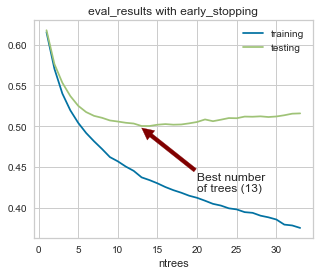

In [13]:
# Testing score is best at 13 trees
results = xg.evals_result()
fig, ax = plt.subplots(figsize=(8, 4))
ax = (pd.DataFrame({'training': results['validation_0']['logloss'],
'testing': results['validation_1']['logloss']})
.assign(ntrees=lambda adf: range(1, len(adf)+1))
.set_index('ntrees')
.plot(figsize=(5,4), 
      ax=ax, title='eval_results with early_stopping'))
ax.annotate('Best number \nof trees (13)', xy=(13, .498), 
            xytext=(20,.42), arrowprops={'color':'maroon'})
ax.set_xlabel('ntrees');

This is an example of how to visualize the performance of an XGBoost classifier during training using the `.evals_result` method and the matplotlib library in Python.

First, the `.evals_result` method is called on the `xg` classifier object to get the evaluation results for each round of training. The results are stored in a variable named `results`.

Next, a new `figure` and `axes` are created using the subplots function from the `matplotlib.pyplot` module. The figure size is set to 8 by 4 inches.
```python
fig, ax = plt.subplots(figsize=(8, 4))
```
Then, a new DataFrame is created from the results dictionary. The DataFrame has two columns: one for the training log loss and one for the testing log loss. A new column named `ntrees` is added to the DataFrame using the `.assign` method. This column contains the number of trees used in each round of training.

The DataFrame is then plotted using the plot method. The ntrees column is set as the index of the DataFrame and used as the x-axis of the plot. The training and testing log loss values are plotted on the y-axis. The figure size is set to 5 by 4 inches and the title of the plot is set to ‘eval_results with early_stopping’.

```python
ax = (pd.DataFrame({'training': results['validation_0']['logloss'],
'testing': results['validation_1']['logloss']})
.assign(ntrees=lambda adf: range(1, len(adf)+1))
.set_index('ntrees')
.plot(figsize=(5,4), 
      ax=ax, title='eval_results with early_stopping'))
```

An annotation is added to the plot using the annotate method on the axes object. The annotation text is ‘Best number of trees (13)’ and it is placed at coordinates (13, .498) on the plot. An arrow pointing to these coordinates is added using the arrowprops parameter.

Finally, the x-axis label is set to ‘ntrees’ using the set_xlabel method on the axes object.

```python
ax.annotate('Best number \nof trees (13)', xy=(13, .498), 
            xytext=(20,.42), arrowprops={'color':'k'})
ax.set_xlabel('ntrees');
```
This code generates a plot that shows how the log loss on both the training and testing datasets changes as more trees are added to the XGBoost model during training. The plot can be used to determine the optimal number of trees for the model based on its performance on the test dataset.

Let us train a model with 13 trees or estimators and see how the model
performs:

In [14]:
# Using value from early stopping gives same result
xg13 = xgb.XGBClassifier(n_estimators=13)
xg13.fit(X_train, y_train, 
         eval_set=[(X_train, y_train), 
                   (X_test, y_test)])
xg13.score(X_test, y_test)

[0]	validation_0-logloss:0.61534	validation_1-logloss:0.61775
[1]	validation_0-logloss:0.57046	validation_1-logloss:0.57623
[2]	validation_0-logloss:0.54011	validation_1-logloss:0.55333
[3]	validation_0-logloss:0.51965	validation_1-logloss:0.53711
[4]	validation_0-logloss:0.50419	validation_1-logloss:0.52511
[5]	validation_0-logloss:0.49176	validation_1-logloss:0.51741
[6]	validation_0-logloss:0.48159	validation_1-logloss:0.51277
[7]	validation_0-logloss:0.47221	validation_1-logloss:0.51040
[8]	validation_0-logloss:0.46221	validation_1-logloss:0.50713
[9]	validation_0-logloss:0.45700	validation_1-logloss:0.50583
[10]	validation_0-logloss:0.45062	validation_1-logloss:0.50430
[11]	validation_0-logloss:0.44533	validation_1-logloss:0.50338
[12]	validation_0-logloss:0.43736	validation_1-logloss:0.50033


0.7558011049723757

let’s look at the model that creates exactly 100 trees. The score is worse than only
using 13

In [15]:
# No early stopping, uses all estimators
xg_no_es = xgb.XGBClassifier()
xg_no_es.fit(X_train, y_train)
xg_no_es.score(X_test, y_test)

0.7458563535911602

The early_stopping_rounds parameter helps to
prevent overfitting and improves performance.

## 10.3 Different eval_metrics
The eval_metric options for XGBoost are metrics used to evaluate the results of an XGBoost
model. They provide a way to measure the performance of a model on a dataset. Some of the
most common eval_metric options for classification are:
1. Log loss ('logloss') - The default measure. Log loss measures a model’s negative log-likelihood performance that predicts a given class’s probability. It penalizes incorrect predictions more heavily than correct ones.
2. Area under the curve ('auc') - AUC is used to measure the performance of a binary classification model. It is the Area Under a receiver operating characteristic Curve.
3. Accuracy ('error') - Accuracy is the percent of correct predictions. XGBoost uses the error, which is one minus accuracy because it wants to minimize the value.
4. You can also create a custom function for evaluation. In the following example, I set the eval_metric to 'error'.

In [16]:
xg_err = xgb.XGBClassifier(early_stopping_rounds=20, eval_metric='error')
xg_err.fit(X_train, y_train, 
           eval_set=[(X_train, y_train), (X_test, y_test)])
xg_err.score(X_test, y_test)

[0]	validation_0-error:0.24739	validation_1-error:0.27072
[1]	validation_0-error:0.24218	validation_1-error:0.26188
[2]	validation_0-error:0.23839	validation_1-error:0.24751
[3]	validation_0-error:0.23697	validation_1-error:0.25193
[4]	validation_0-error:0.23081	validation_1-error:0.24530
[5]	validation_0-error:0.22607	validation_1-error:0.24420
[6]	validation_0-error:0.22180	validation_1-error:0.24862
[7]	validation_0-error:0.21801	validation_1-error:0.24862
[8]	validation_0-error:0.21280	validation_1-error:0.25304
[9]	validation_0-error:0.21043	validation_1-error:0.25304
[10]	validation_0-error:0.20806	validation_1-error:0.24641
[11]	validation_0-error:0.20284	validation_1-error:0.25193
[12]	validation_0-error:0.20047	validation_1-error:0.24420
[13]	validation_0-error:0.19668	validation_1-error:0.24420
[14]	validation_0-error:0.19384	validation_1-error:0.24530
[15]	validation_0-error:0.18815	validation_1-error:0.24199
[16]	validation_0-error:0.18531	validation_1-error:0.24199
[17]	va

0.7624309392265194

In [17]:
xg_err.best_ntree_limit

19

Now, the best number of trees when we minimize error is 19.